In [1]:
import os
import time
import tqdm
import numpy as np
import pandas as pd
import json
import itertools
import sys
import yaml
import matplotlib.pyplot as plt

from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests

sys.path.append(os.path.expanduser('~'))
from PpaPy.helper.io import makedir
from functions import io
from functions.process import safe_round_matrix
from functions.read_write import NanConverter, load_data_from_keys, iterable_exps
from functions.batch_plots import sig_stars, find_common, find_uncommon, StateConditionBoxplot, transplot, EthogramPlotter
from functions.batch_stats import append_df_to_multi, BatchCondition, MannWhitneyU_frommultidf, BatchTransitions_frommultidf
import PpaPy.plot2 as vis

import warnings
warnings.filterwarnings(action='ignore', message='Mean of empty slice')

In [2]:
config_path = "config.yml"
config = yaml.safe_load(open(config_path, "r"))

# recording
fps = config['settings']['fps']

# path
inpath = config['path']['predictions']
base_out = config['path']['analysis']
jsonpath = makedir(os.path.join(base_out, os.path.basename(inpath)))
inpath_with_subfolders = config['path']['with subfolders']
overwrite = config['settings']['overwrite batch']

# coloring and labels
cluster_color = config['cluster_color']
cluster_label = config['cluster_labels']

skip_already = config['settings']['skip_already']

pctl_toplot = eval(config['plot_settings']['percentiles'])
showfliers = config['plot_settings']['showfliers']
bonferroni = config['plot_settings']['bonferroni']
Z = eval(config['plot_settings']['Z'])
test_metrics = config['plot_settings']['test_metrics']

In [3]:
config_batch_path = "config_batch.yml"
config_batch = yaml.safe_load(open(config_batch_path, "r"))

run_exps, exps_include, exps_statpop = iterable_exps(config_batch)

In [4]:
run_exps, exps_include, exps_statpop 

(['WTvsmec6'], [['L147', 'L176']], ['L147'])

Json file not found. Json will be created first.


100%|██████████| 105/105 [01:06<00:00,  1.57it/s]


Json file not found. Json will be created first.


100%|██████████| 103/103 [00:51<00:00,  2.01it/s]


[0.01]


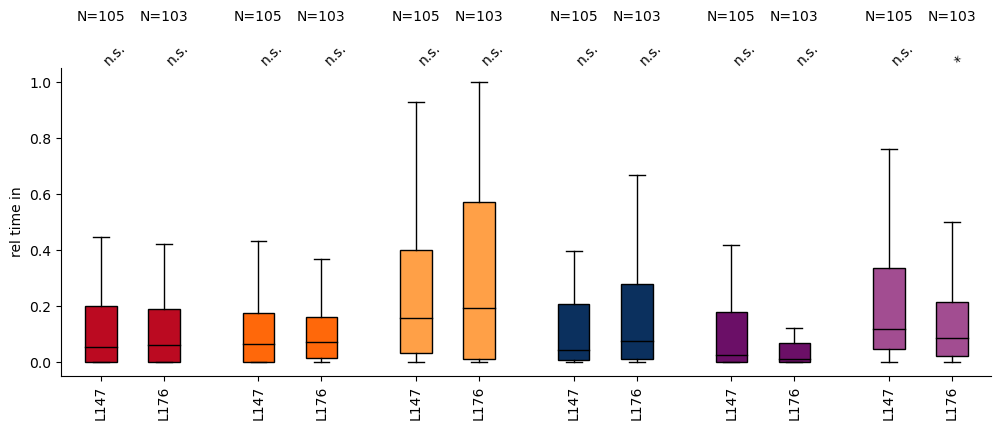

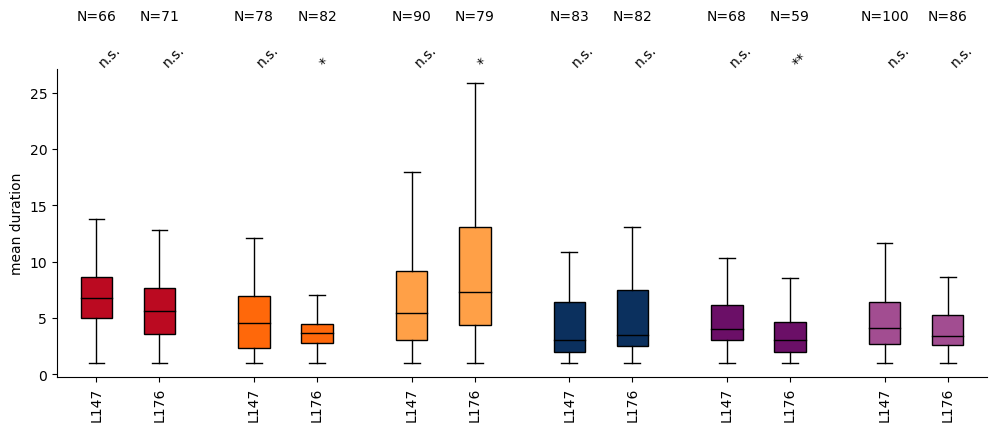

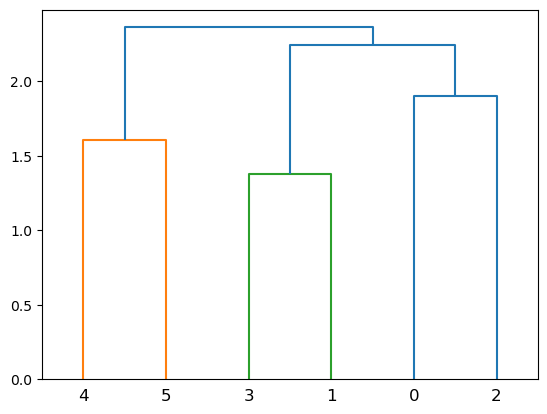

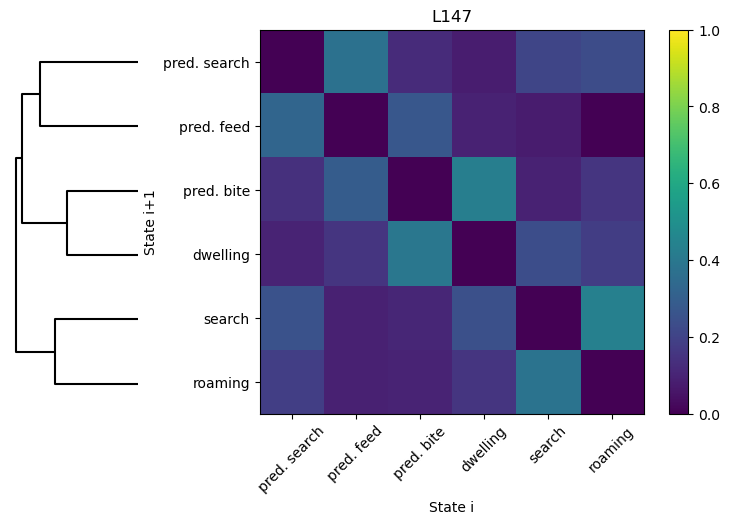

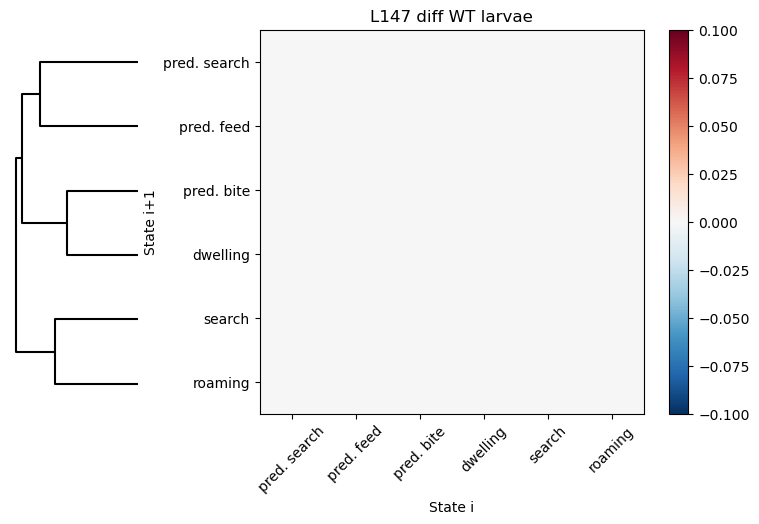

None


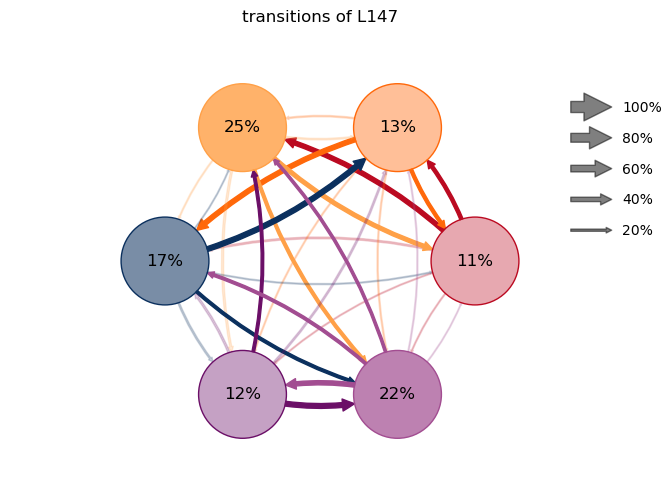

L147 0    0.354839
1    0.419355
2    0.806452
3    0.548387
4    0.387097
5    0.709677
Name: L147, dtype: float64


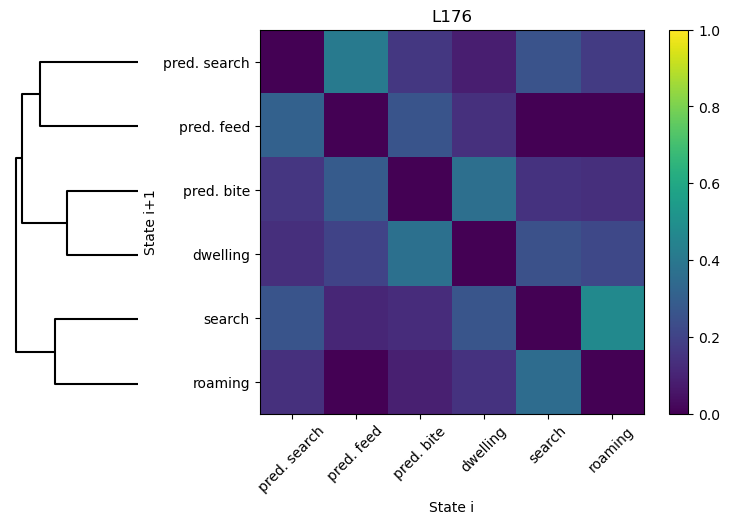

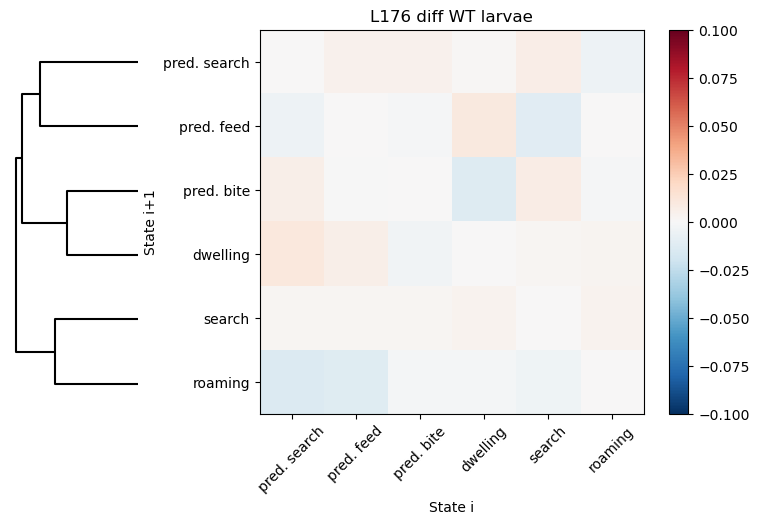

None


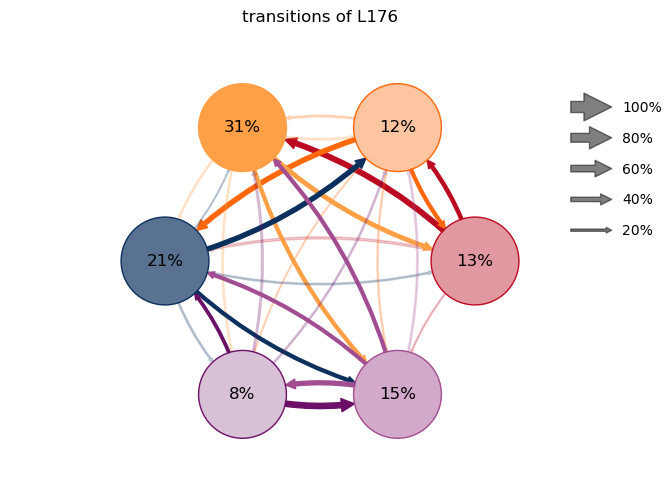

L176 0    0.419355
1    0.387097
2    1.000000
3    0.677419
4    0.258065
5    0.483871
Name: L176, dtype: float64


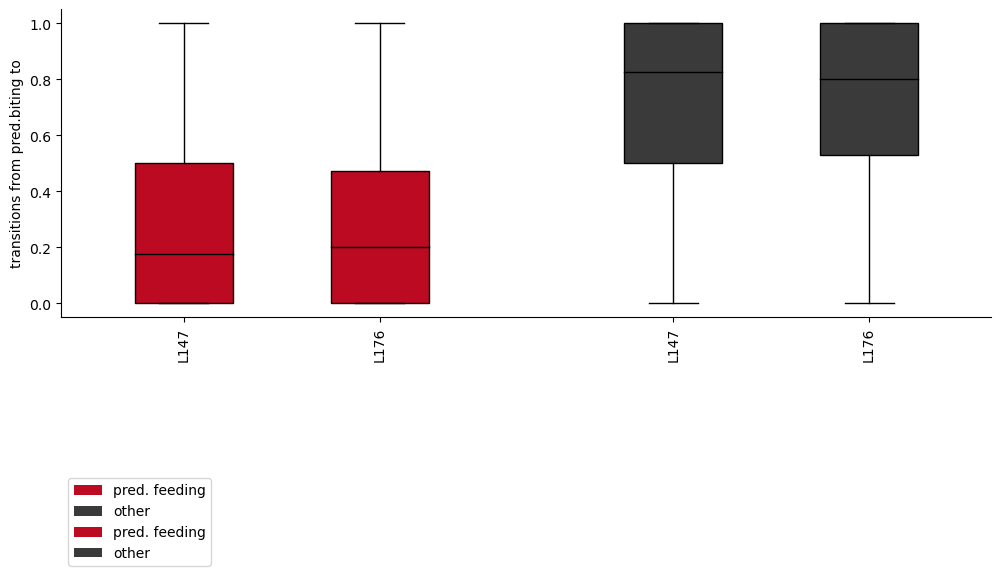

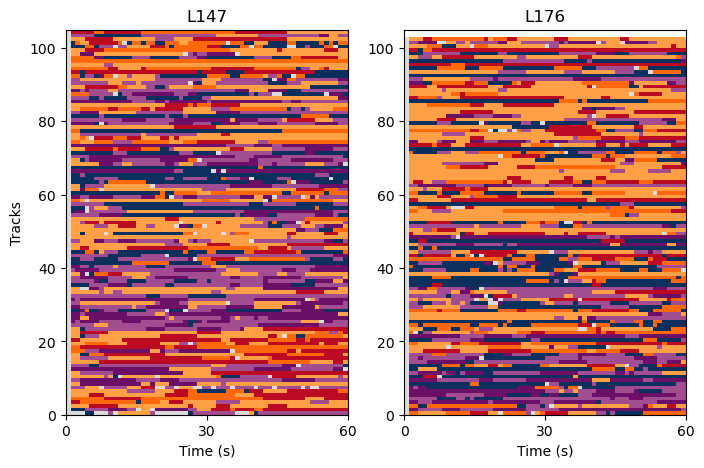

In [5]:
for fig_folder, include, stat_pop in zip(run_exps, exps_include, exps_statpop):
    exp_loc_batch = {}
    N_bonf_tests = len(include)-1
    exp_out = makedir(os.path.join(jsonpath, fig_folder))
    
    # iterate through metrics to be analysed
    for metric in test_metrics:
        metric_out = os.path.join(exp_out, f"{time.strftime('%Y%m%d')}_{''.join(metric.split(' '))}")
        # create a multiindex DataFrame from Batch Files, If Batch files do not exist yet, creates them
        metric_multi = None
        for data_str in include:
            batch = BatchCondition(inpath, data_str, jsonpath)
            batch.load_json()
            exp_loc_batch[data_str] = batch.jsonpath

            metric_multi = append_df_to_multi(batch.load_data_from_keys(metric), data_str, metric_multi)
    
        #TODO: check if needed
        metric_multi.index.name = 'state'
        
        # normalisations
        #TODO: check if correct
        if metric == 'mean duration':
            metric_multi = metric_multi/fps
        if metric == 'rel time in':
            metric_multi = metric_multi/metric_multi.sum(axis=0)
            nodes_alpha = metric_multi.groupby(level=0, axis=1).mean()
            nodes_alpha = pd.DataFrame(safe_round_matrix(nodes_alpha.values, axis=0), columns=nodes_alpha.columns)

        if metric != 'ethogram':
            # performs statistics on the multiindex DataFrame
            stats_csv = MannWhitneyU_frommultidf(metric_multi, fig_folder, stat_pop, bonferroni, N_bonf_tests).iterate_conditions()
            stats_csv.to_csv(metric_out + '_MannWhitneyUTable.csv')

        ### make boxplots
        if metric == 'mean duration' or metric == 'rel time in':
            metric_boxplot = StateConditionBoxplot(metric_multi, cluster_color, stats_csv, metric, bonferroni, showfliers=showfliers).plot()
            metric_boxplot.savefig(metric_out + '_boxplot.pdf',bbox_inches="tight")
            plt.show()

        ### make transitions  
        elif metric == 'mean transitions':
            batch_transitions = BatchTransitions_frommultidf(metric_multi, with_self=False, norm_over='out', Z=Z)
            all_trans_norm_out = batch_transitions.normalize_multi()
            if Z is None:
                Z = batch_transitions.linkage()
            ordering = batch_transitions.dendrogram()['leaves'][::-1]
            
            for cond in all_trans_norm_out:
                np.round(all_trans_norm_out[cond],4).to_csv(metric_out + cond + '_transitions.csv')
                transplot_cond = transplot(all_trans_norm_out[cond], cluster_label, ordering, linked=Z, label=cond)
                transplot_cond.savefig(metric_out + cond + '_transplot.pdf',bbox_inches="tight")
                plt.show()
            
                trans_rel = (all_trans_norm_out[cond]-all_trans_norm_out[stat_pop])*nodes_alpha[cond].values
                transplot_diff = transplot(trans_rel, cluster_label, ordering,  cmap='RdBu_r',linked=Z, vmin=-.1,vmax=.1, label=cond+' diff WT larvae')#linked=Z, 
                transplot_diff.savefig(metric_out + cond + '_reltransplot.pdf',bbox_inches="tight")
                plt.show()

                circle_trans_plot = vis.transitions_plotter_percentage(all_trans_norm_out[cond], nodes_alpha[cond], cluster_color, cond, edge_prob_thresh = 0.2, maxout_nodeprob=np.max(nodes_alpha.values))
                plt.title(f"transitions of {cond}")
                circle_trans_plot.savefig(metric_out + cond + '_networkplot.pdf',bbox_inches="tight")
                plt.show()

                print(cond, nodes_alpha[cond]/np.max(nodes_alpha.values))
            
            # plot to grouped transitions from pred. biting to pred. feeding and other states
            metric_multi_fromstate = batch_transitions.multi_df[batch_transitions.multi_df.index.get_level_values(0) == 1].copy()
            metric_multi_fromstate = metric_multi_fromstate[metric_multi_fromstate.index.get_level_values(1) != 1]
            TransFromState = StateConditionBoxplot(metric_multi_fromstate, {0:'#BB0A21', 1:'#3A3A3A'}, showfliers=showfliers, showlegend=True, cluster_label={0:'pred. feeding', 1:'other'}, y_label='transitions from pred.biting to')
            boxplot_grouped = TransFromState.plot_groups([[0]])
            boxplot_grouped.savefig(metric_out + '_transitions_grouped_boxplot.pdf',bbox_inches="tight")
            
        ### make stacked ethogram
        elif metric == 'ethogram':
            etho = EthogramPlotter(metric_multi, cluster_color, cluster_label, fps, plot_fps=2, xtick_spread = 30, multi_level=0)
            stacked_etho = etho.multi_stack(xlim=(0,60), ylim=(0,max(np.unique(metric_multi.columns.get_level_values(0), return_counts=True)[1])));
            stacked_etho.savefig(metric_out + '_stackedethoplot.pdf',bbox_inches="tight")
            plt.show()
        overwrite = False